In [1]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

experiment_name = "M2"

algorithms = []
algorithms.append("MFRecommender")
# algorithms.append("BRISMFRecommender")

forgetting = []
# forgetting.append("NoForgetting")
forgetting.append("UserFactorFading")
forgetting.append("SDUserFactorFading")
forgetting.append("MappedUserFactorFading")
forgetting.append("ForgetUnpopularItems")

parameters = [1.02, 0.99, 1.01, 1.1, 100]


configs = (("NoForgetting", None), ("UserFactorFading", 1.02), ("SDUserFactorFading", 100), ("MappedUserFactorFading", 0.99), ("ForgetUnpopularItems", 1.01))
configs = (("NoForgetting", None), ("NoForgetting", 1))
#configs = (("UserFactorFading", 1.02))

files = []

# for rec in algorithms:
#     for f, p in configs:
#         files.append("{}_{}_{}_{}.dat".format(rec, f, p, experiment_name))

# for rec in algorithms:
#     for f in forgetting:
#         for p in parameters:
#             files.append("{}_{}_{}_{}.dat".format(rec, f, p, experiment_name))

files.append("MFRecommender_NoForgetting_1_M2.dat")
# files.remove("MFRecommender_MappedUserFactorFading_1.4_M1.dat")
# files.remove("MFRecommender_MappedUserFactorFading_1.2_M1.dat")
            
__RECALLAT__ = 10

In [2]:
class Recall:
    def __init__(self, n):
        self.n = n
        self.hits = 0
        self.stream = 0 
    def update(self, rank):
        if rank <= self.n:
            self.hits += 1
        self.stream += 1
        return self.score()
    def score(self):
        return self.hits/self.stream
    
class Position:
    def update(self, rank):
        print(rank)
        return (1002 - rank)/1001

In [3]:
# (top-1 score, where the correct item is ranked, rec time, update time)

defined = False
recallDF = None
uptimeDF = None
rectimeDF = None
for file in files:
    metric = Recall(__RECALLAT__)
    with open("D:\\recsys\\flurs\\results\\{}".format(file)) as f:
        file = file.replace('.dat','')
        file = file.replace('Recommender_','/')
        data = f.read().split(')')
        data.remove('')
        recallList = []
        uptimeList = []
        rectimeList = []
        indexList = []
        for index, line in enumerate(data):
            line = line.replace('(','')
            line = line.replace(' ','')
            info = line.split(',')
            recallList.append(metric.update(int(info[1])))
            uptimeList.append(float(info[2]))
            rectimeList.append(float(info[3]))
            indexList.append(index)
        if defined:
            recallDF = recallDF.merge(pd.DataFrame({file : recallList, "Index": indexList}), on='Index', how='left')
            uptimeDF = uptimeDF.merge(pd.DataFrame({file : uptimeList, "Index": indexList}), on='Index', how='left')
            rectimeDF = rectimeDF.merge(pd.DataFrame({file : rectimeList, "Index": indexList}), on='Index', how='left')
        else:
            defined = True
            recallDF = pd.DataFrame({"Index": indexList, file : recallList})
            uptimeDF = pd.DataFrame({"Index": indexList, file : uptimeList})
            rectimeDF = pd.DataFrame({"Index": indexList, file : rectimeList})

recallDF = recallDF.drop(columns=['Index'])
uptimeDF = uptimeDF.drop(columns=['Index'])
rectimeDF = rectimeDF.drop(columns=['Index'])

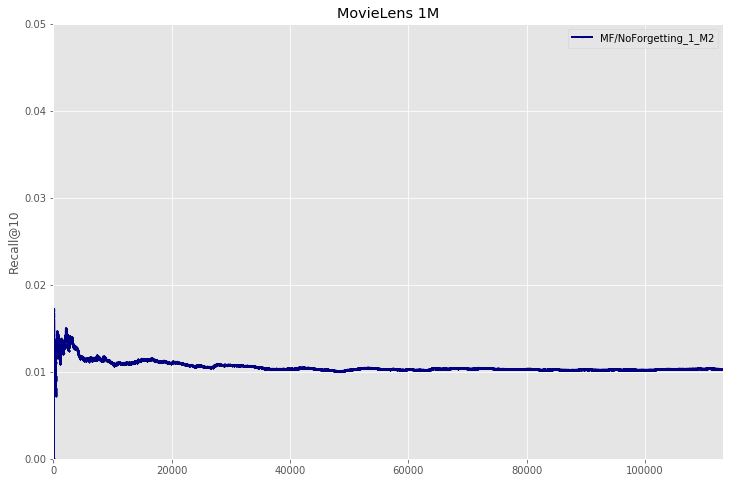

In [4]:
plt.rcParams['figure.figsize'] = (12,8)
with plt.style.context(('ggplot')):
    ax = recallDF.plot(lw=2, colormap='jet', marker='.', markersize=1, title="MovieLens 1M")
    plt.ylim([0,0.05])
    ax.set(xlabel="", ylabel='Recall@{}'.format(__RECALLAT__))

In [5]:
recallDF.mean()

MF/NoForgetting_1_M2    0.010585
dtype: float64